In these types of machine learning problems to predict fuel efficiency, we aim to predict the output of a continuous value, such as a price or a probability.

### Predict Fuel Efficiency

Here we will use one of the famous datasets among machine learning practitioners, **Auto MPG** dataset to create a model to predict fuel efficiency of vehicles in the late 1970s and early 1980s. To do this, we will provide the model with a description of many automobiles from this period. This description includes attributes such as cylinders, displacement, horsepower and weight.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\Waqas.Ali\\.keras\\datasets\\auto-mpg.data'

In [10]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [11]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
dataset = dataset.dropna()

The `origin` column in the dataset is categorical, so to move forward we need to use some one-hot encoding on it:

In [13]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Let’s split the data into training and test sets:

In [14]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Before training and test to predict fuel efficiency with machine learning, let’s visualize the data by using the seaborn’s pair plot method:

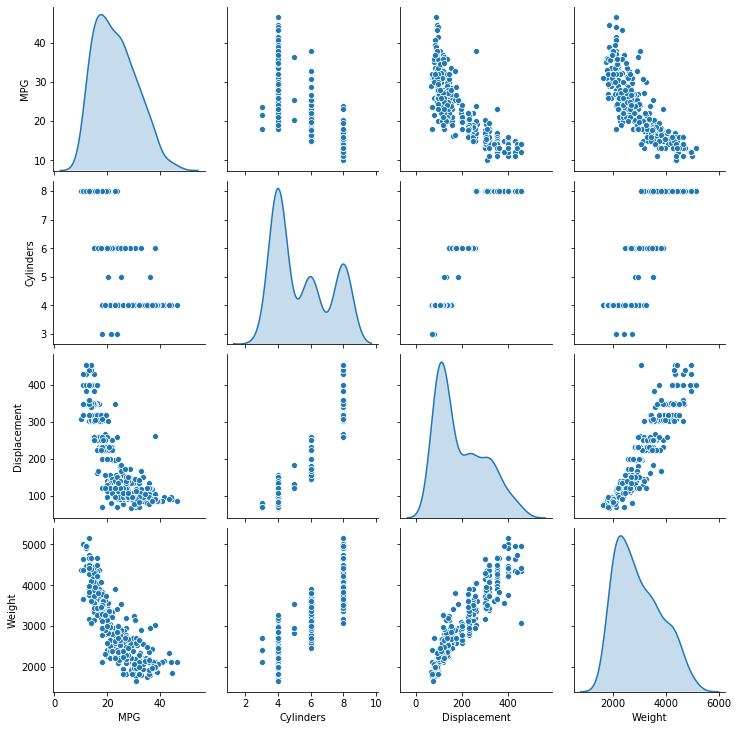

In [16]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

Now, we will separate the target values from the features in the dataset. This label is that feature that we will use to train the model to predict fuel efficiency:

In [17]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [18]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize The Data

It is recommended to standardize features that use different scales and ranges. Although the model can converge without standardization of features, this makes learning more difficult and makes the resulting model dependent on the choice of units used in the input. We need to do this to project the test dataset into the same distribution the model was trained on:

In [19]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [20]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [21]:
normed_test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,0.774676,-0.465148,-0.495225
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,0.774676,-0.465148,-0.495225
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,0.774676,-0.465148,-0.495225
31,-0.869348,-0.789008,-0.259066,-0.903250,-0.559020,-1.332580,-1.286751,-0.465148,2.012852
33,0.307270,0.351586,-0.127819,-0.422150,-0.917542,-1.332580,0.774676,-0.465148,-0.495225


Note: The statistics used to normalize the inputs here (**mean** and **standard deviation**) should be applied to all other data provided to the model, with the one-hot encoding we did earlier. This includes the test set as well as live data when the model is used in production.

### Build The Model
Let’s build our model. Here, we will use the sequential API with two hidden layers and one output layer that will return a single value. The steps to build the model are encapsulated in a function, `build_model`, since we will be creating a second model later:

In [22]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Before training the model to predict fuel efficiency let’s try this model in the first 10 samples:

In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.19108948],
       [-0.09168356],
       [ 0.15135673],
       [-0.12203066],
       [-0.2141396 ],
       [-0.06804266],
       [-0.3037665 ],
       [-0.4231803 ],
       [-0.16869226],
       [ 0.02151436]], dtype=float32)

### Training Model To Predict Fuel Efficiency

Now, let’s train the model to predict fuel efficiency:

In [25]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [26]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.420476,1.016833,2.420476,9.824549,2.329482,9.824549,995
996,2.624681,1.062397,2.624681,9.749179,2.303770,9.749179,996
997,2.462764,1.035749,2.462764,9.825724,2.307307,9.825724,997
998,2.404751,0.997132,2.404751,10.153275,2.352533,10.153275,998
999,2.398860,0.986729,2.398860,10.231993,2.360893,10.231993,999


Let’s visualize the model training:

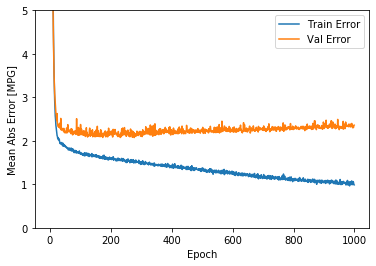

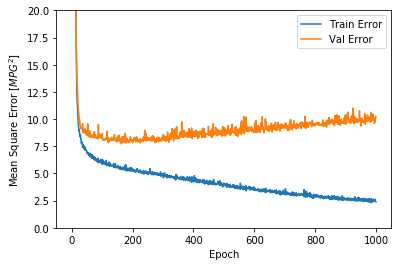

In [28]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph below represents a little improvement or even degradation in validation error after about 100 epochs. Now, let’s update the `model.fit` method to stop training when the validation score does not improve. We’ll be using an **EarlyStopping callback** that tests a training condition for each epoch. If a set number of epochs pass without showing improvement, automatically stop training:


.............................................

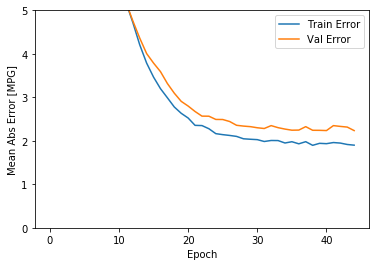

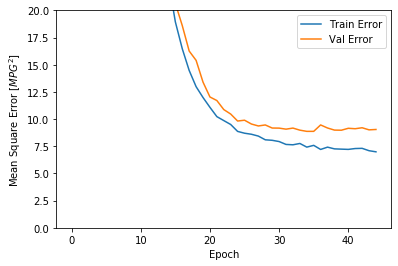

In [29]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that over the validation set, the average error is typically around **+/- 2 MPG**. Is it good? We will leave that decision to you.

Let’s see how the model generalizes using the test set, which we didn’t use when training the model. This shows how well it is expected that model to predict when we use it in the real world:

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.4366 - mae: 1.9561 - mse: 6.4366
Testing set Mean Abs Error:  1.96 MPG


Now, let’s make predictions on the model to predict fuel efficiency:

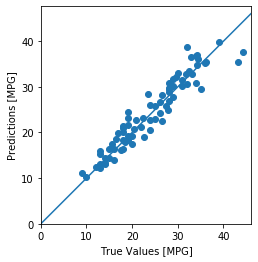

In [31]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like that the model predicted well.

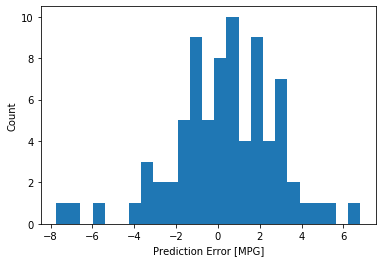

In [32]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### Conclusion

This project introduced some techniques for handling a regression problem.

* The **root mean square error (MSE) is a common loss function used for regression problems** (different loss functions are used for classification problems).
* Similarly, the evaluation metrics used for the regression differ from the ranking. A **common regression metric is mean absolute error (MAE)**.
* When numeric input data characteristics have values with different ranges, each characteristic must be independently scaled to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to avoid overfitting.